# Ticket-Price-Predictor
A machine learning predictor to help predict the price of a flight ticket.

Dataset: https://www.kaggle.com/datasets/dilwong/flightprices

Libraries used: Pandas, Numpy, Matplotlib, Seaborn, Sklearn

In [4]:
# Import the necessary libraries 
import pandas as pd
import numpy as np

print("Imported successfully")

Imported successfully


## Dataset Splitting

As our dataset is roughly 30GBs unzipped, it would take an impossibly long time to run this on any of my machines, so I decided to split the dataset into multiples of 50000 rows csv files (using an external program), then combine three randomly selected files into one csv file for a total for 150k rows.

Afterwards, I imported the 150k csv file into a pandas dataframe and used pandas's sample to sample the dataframe into a new dataframe with 8000 rows and saved into a new csv file to reimport later on.

In [356]:
# Read the data
data = pd.read_csv('dataset/combine/combined-csv-files.csv')

# Randomised the data to 8000 rows (from the original 150000 rows)
data.sample(8000).to_csv('dataset/combine/combined-csv-files-sample.csv', index=False)

C:\Users\putty\AppData\Local\Temp/ipykernel_22788/723826931.py:2: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset/combine/combined-csv-files.csv')


## Data Exploration

**NOTE: This will now act as the entry point for the notebook, after running the first Code cell for imports and skipping the second Code cell.**

After importing the new 8000 rows csv file into a pandas dataframe, I used the head() function to get a quick look at the data.

We can see that the dataset has a few columns prefixed with 'segments' and we can see from the sample rows inside these columns that they are separated by ||, we can safely **assume** that the more separators there are, the more segments the flight has. i.e. `segmentsDistance = 720||1745||338` means the flight has 3 segments, with the first segment being 720 miles, the second segment being 1745 miles and the third segment being 338 miles.


In [374]:
# Loading the 8000 rows dataset 

df = pd.read_csv('dataset/combine/combined-csv-files-sample.csv')

df.describe()


,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance
count,8000.000000,8000.000000,8000.000000,8000.000000,7521.000000
mean,0.135625,315.162041,364.174667,5.555500,1570.238399
std,0.342776,213.800209,229.393129,2.941598,835.462070
min,0.000000,5.100000,30.690000,0.000000,97.000000
25%,0.000000,180.470000,218.600000,3.000000,868.000000
50%,0.000000,284.490000,329.600000,7.000000,1429.000000
75%,0.000000,404.650000,458.600000,7.000000,2358.000000
max,2.000000,2475.350000,2690.200000,10.000000,3958.000000


### Data Exploration: Graphs

We can see from the following few graphs that, depending on a number of factors, the price of a flight ticket can vary greatly.

**First Graph**: Average Price of Flights by Airline *(shows if the airline matters for the price of a ticket)*

**Second Graph**: Average Price of Flights by Flight Time *(shows the longer a flight is, the higher the price of a ticket)*

**Third Graph**: Average Price of Flights by Days Before Departure *(shows that the closer the departure date is to the current date, the higher the price of a ticket)*

**Fourth Graph**: Number of flights coming out of an Airport and how many are going to which airport

<AxesSubplot: title={'center': 'Average Price of Flights by Airline'}, xlabel='airlineName'>

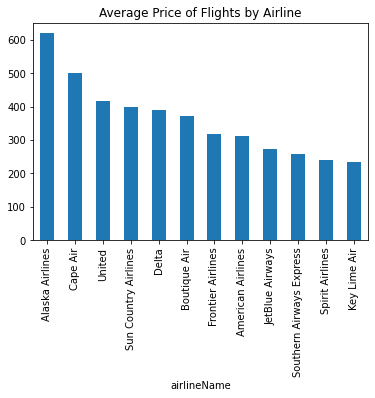

In [375]:
# This creates a new column which is the airline that operates the first segment of the flight, typically the airline that you book with in the first place.

df['airlineName'] = df['segmentsAirlineName'].str.rsplit('||', expand=True)[0]

# Creates a graph of the average price of flights by airline

df.groupby('airlineName')['totalFare'].mean().sort_values(ascending=False).plot(kind='bar', title='Average Price of Flights by Airline')

c:\Users\putty\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arrays\timedeltas.py:1001: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  data = objects_to_td64ns(data, unit=unit, errors=errors)


<AxesSubplot: title={'center': 'Average Price of Flights by Flight Time'}, xlabel='travelTime'>

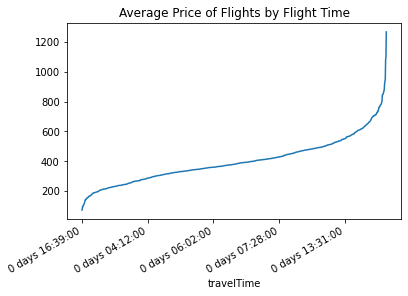

In [376]:
# Creates a new column, which is the converted travel duration from a string to a time delta for us to be able to easily manipulate the data later on

df['travelTime'] = pd.to_timedelta(df['travelDuration'].str.replace('PT', ''))

# Creates a graph of the average price of flights by flight time

df.groupby('travelTime')['totalFare'].mean().sort_values(ascending=True).plot(kind='line', title='Average Price of Flights by Flight Time')

<AxesSubplot: title={'center': 'Average Price of Flights by Days Before Departure'}, xlabel='daysBeforeDeparture'>

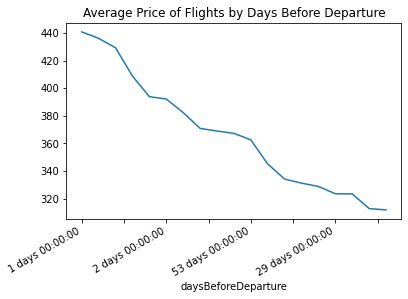

In [377]:
# Creates a new column 'daysBeforeDeparture' to show the number of days before the flight's departure date (flightDate - searchDate)

df['daysBeforeDeparture'] = pd.to_datetime(df['flightDate']) - pd.to_datetime(df['searchDate'])

# Creates a graph to show the correlation between days before departure and price

df.groupby('daysBeforeDeparture')['totalFare'].mean().sort_values(ascending=False).plot(kind='line', title='Average Price of Flights by Days Before Departure')

<AxesSubplot: title={'center': 'Number of Flights by Airport'}, xlabel='startingAirport'>

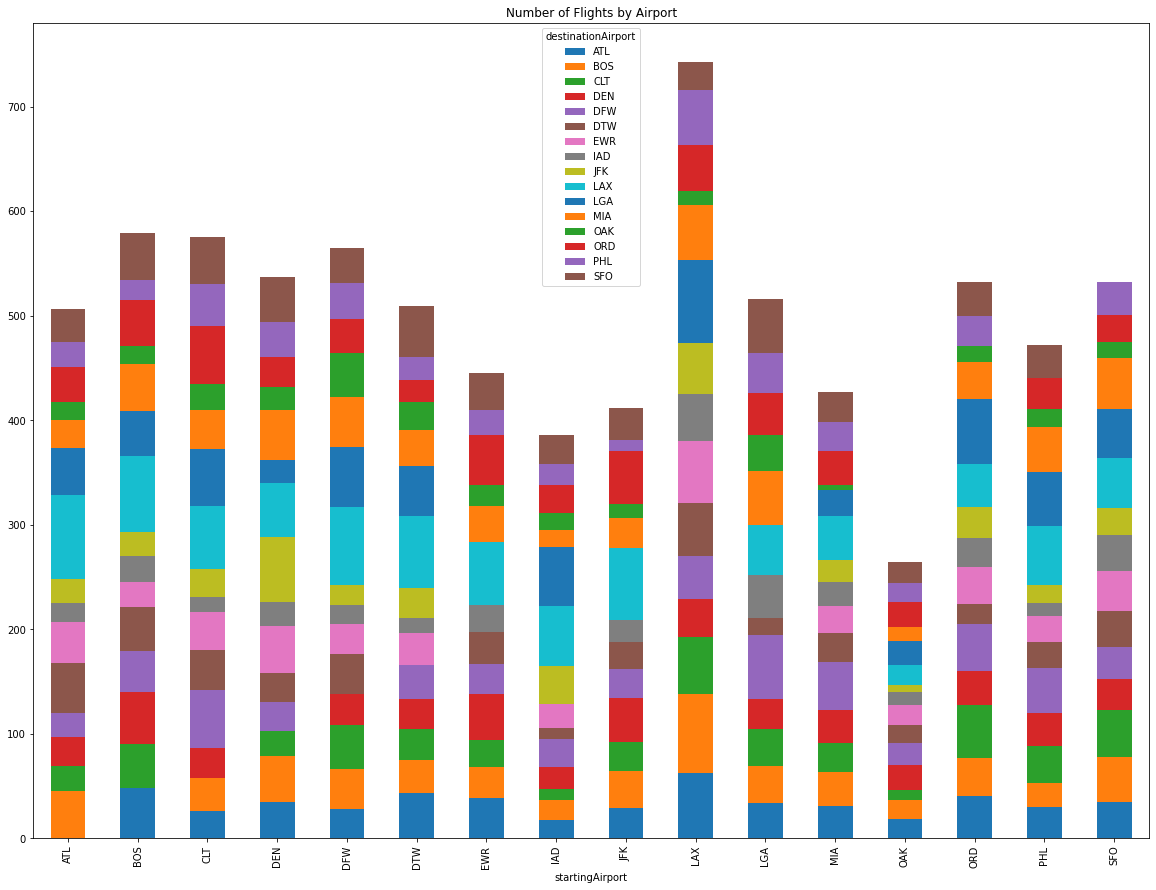

In [378]:
# Creates a stacked bar chart to show the number of flights coming out of an airport, and how many flights from that airport goes to another airport
df.groupby(['startingAirport', 'destinationAirport']).size().unstack().plot(kind='bar', stacked=True, title='Number of Flights by Airport', figsize=(20, 15))


## Data Pre-processing

We'll now need to pre-process the data to make it easier for the machine learning model to understand.

### Data Pre-processing: Removing Obsolete Columns

We created three columns earlier on to help us with our data exploration, we can now remove the original columns that we used to derive these new columns.
| New Column | Original Column | Reason |
| --- | --- | --- |
| `airlineName` | `segmentsAirlineName` | After we have extracted the first segment's airline name, we can remove the original column |
| `travelTime` | `travelDuration` | We have converted the original column's value into a more manipulatable format |
| `daysBeforeDeparture` | `flightDate` and `searchDate` | `daysBeforeDeparture` is an easier to use column than flightDate and searchDate |

So we can now remove these original columns from our dataframe.


In [379]:
# remove segmentsAirlineName, travelDuration, flightDate, searchDate
df = df.drop(['segmentsAirlineName', 'travelDuration', 'flightDate', 'searchDate'], axis=1)

# check that the columns have been removed correctly
df.head(6)

,legId,startingAirport,destinationAirport,fareBasisCode,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,...,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,airlineName,travelTime,daysBeforeDeparture
0,535b0db761369fc82e6e20ffbf0c2961,LGA,LAX,QAA0KKEN,0.0,False,False,False,340.47,389.61,...,IAD||LAX,LGA||IAD,UA||UA,Embraer 175 (Enhanced Winglets)||Boeing 737-900,5880||19680,221||2295,coach||coach,United,0 days 08:46:00,48 days
1,ae2ee04df190b4a3b3d86de847860ecc,DEN,DTW,K0AIZNN1,0.0,False,False,False,373.95,424.10,...,CLT||DTW,DEN||CLT,AA||AA,Airbus A321||Boeing 737-800,11820||6480,1346||505,coach||coach,American Airlines,0 days 06:33:00,31 days
2,2efe95e89f76ee18169f68553e3037cf,DFW,BOS,H0AJZNN1,0.0,False,False,True,485.58,536.60,...,BOS,DFW,AA,Airbus A321,13500,1556,coach,American Airlines,0 days 03:45:00,30 days
3,86c9e9c2064348f556b7f0abd7352c4f,IAD,DEN,LA3OA0BG,0.0,True,False,False,190.70,228.60,...,DTW||DEN,IAD||DTW,DL||DL,Canadair Regional Jet 900||Airbus A321,5820||11580,391||1142,coach||coach,Delta,0 days 06:31:00,5 days
4,b53afb250f4fa14bdf01fb8031b154df,JFK,CLT,SVAHZNN1,0.0,False,False,False,166.52,202.61,...,ORF||CLT,JFK||ORF,AA||AA,Embraer 175||Canadair Regional Jet 900,5280||4980,301||290,coach||coach,American Airlines,0 days 04:37:00,52 days
5,6ac0f132bc14123e3958779e19f8eb58,OAK,LGA,KAUOA0MQ,0.0,False,False,False,714.42,796.10,...,LAX||DEN||LGA,OAK||LAX||DEN,DL||UA||UA,Embraer 175 (Enhanced Winglets)||Boeing 737-80...,5100||8640||14100,338||848||1621,coach||coach||coach,Delta,0 days 12:50:00,51 days


### Data Pre-processing: Removing Unnecessary Columns

We can also remove some columns that we don't need for our machine learning model.
| Column | Reason |
| --- | --- |
| `legId` | We don't need this column as it is just a unique identifier for flight |
| `fareBasisCode` | We don't need this column as it is typically an unique identifier by airlines for their fares and would not help our model |
| `elapsedDays` | This column represents the days that has passed since the flight has *taken off*, as we're aiming to predict the price when booking a ticket, we can safely assume the flight has not taken off yet, and that the majority of the data's value is 0 |
| `baseFare` | This is the price of the ticket before any taxes and fees are added, we can remove this and assume that we'll be predicting prices that are after taxes and fees |
| `seatsRemaining` | This column represents the number of seats left on the flight, we can remove this column as we don't need it for our model |
| `segments---` | We can remove all the columns that are prefixed with `segments` as these columns are hard to manipulate and will only result in inconsistency in our model (except for `segmentsCabinCode`, as we'll extract it later) |


In [380]:
# remove the columns legId, fareBasisCode, elapsedDays, baseFare, seatsRemaining and all the columns with the word 'segments' in them
df = df.drop(['legId', 'fareBasisCode', 'elapsedDays', 'baseFare', 'seatsRemaining'], axis=1)
df = df.drop(['segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 'segmentsDistance'], axis=1)

# check that the columns have been removed correctly
df.head(6)

,startingAirport,destinationAirport,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,segmentsCabinCode,airlineName,travelTime,daysBeforeDeparture
0,LGA,LAX,False,False,False,389.61,2516.0,coach||coach,United,0 days 08:46:00,48 days
1,DEN,DTW,False,False,False,424.10,1851.0,coach||coach,American Airlines,0 days 06:33:00,31 days
2,DFW,BOS,False,False,True,536.60,1556.0,coach,American Airlines,0 days 03:45:00,30 days
3,IAD,DEN,True,False,False,228.60,1533.0,coach||coach,Delta,0 days 06:31:00,5 days
4,JFK,CLT,False,False,False,202.61,591.0,coach||coach,American Airlines,0 days 04:37:00,52 days
5,OAK,LGA,False,False,False,796.10,2807.0,coach||coach||coach,Delta,0 days 12:50:00,51 days


### Data Pre-processing: Removing Rows with Missing Values

We can also remove rows that have missing values, as we can't use them for our model.

First, we'll check which columns have rows of missing values and proceed to remove the rows with missing values in those columns.

We can see that `totalTravelDistance` has 479 rows with missing values inside our dataframe, we can fill these missing values with the mean of the `totalTravelDistance` of the same `startingAirport` and `destinationAirport`.

After that, we can check again and see that we've successfully filled in all the rows with missing values.

In [381]:
# Checks for missing values in the dataset
df.isnull().sum()

# Fills in the missing values rows with the mean totalDistance of the startingAirport and destinationAirport of the same from the missing value row
df['totalTravelDistance'] = df.groupby(['startingAirport', 'destinationAirport'])['totalTravelDistance'].transform(lambda x: x.fillna(x.mean()))

# Checks for missing values again
df.isnull().sum()

startingAirport        0
destinationAirport     0
isBasicEconomy         0
isRefundable           0
isNonStop              0
totalFare              0
totalTravelDistance    0
segmentsCabinCode      0
airlineName            0
travelTime             0
daysBeforeDeparture    0
dtype: int64

### Data Pre-processing: Feature Extraction

We can now extract the `segmentsCabinCode` column into a new column called `cabinCode` and remove the original column.

Currently it is in the format of `segmentsCabinCode = Y||Y||Y` (where `Y = cabinCode`), we can extract the first value and use it as our new column's value.

We can then see the amount of occurrences for each cabinCode inside the dataset. i.e. how many First Class, Business Class, Premium Economy Class and Economy Class flights are there.
(Note: Coach in the dataset refers to Economy Class)

We can see that there are `7967` Economy Class flights, `19` First Class flights, `11` Premium Economy Class flights and `3` Business Class flights.

Once done, we can safely remove the original `segmentsCabinCode` column.

In [382]:
# Extracts cabinCode from segmentsCabinCode
df['cabinCode'] = df['segmentsCabinCode'].str.rsplit('||', expand=True)[0]

# Checks that the cabinCode column has been created correctly
df.head(6)

# Checks for the amount of occurrences of each cabinCode
df['cabinCode'].value_counts()

# Removes the segmentsCabinCode, as we're done with it
df = df.drop(['segmentsCabinCode'], axis=1)

### Data Pre-processing: Hot Encoding Categorical Columns

As we've cleaned our data, we can now hot encode our categorical columns, primarily `startingAirport`, `destinationAirport`, `airlineName` and `cabinCode`.

In [383]:
# Hot-encodes the categorical columns to turn them into numerical values that our model can use
df = pd.get_dummies(df, columns=['startingAirport', 'destinationAirport', 'airlineName', 'cabinCode'])

# Checks that the hot-encoding has been done correctly
df.head(6)

,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,travelTime,daysBeforeDeparture,startingAirport_ATL,startingAirport_BOS,startingAirport_CLT,...,airlineName_JetBlue Airways,airlineName_Key Lime Air,airlineName_Southern Airways Express,airlineName_Spirit Airlines,airlineName_Sun Country Airlines,airlineName_United,cabinCode_business,cabinCode_coach,cabinCode_first,cabinCode_premium coach
0,False,False,False,389.61,2516.0,0 days 08:46:00,48 days,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,False,False,False,424.10,1851.0,0 days 06:33:00,31 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,False,False,True,536.60,1556.0,0 days 03:45:00,30 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,True,False,False,228.60,1533.0,0 days 06:31:00,5 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,False,False,False,202.61,591.0,0 days 04:37:00,52 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,False,False,False,796.10,2807.0,0 days 12:50:00,51 days,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Data Pre-processing: Converting `Timedelta` values to a numerical value

We can see that `daysBeforeDeparture` and `travelTime` is currently in a type of `Timedelta` and we can't use this for our model, so we'll convert it into a numerical value (and in hours).

In [384]:
# Converts travelTime from Timedelta into a numerical value in hours
df['travelTime'] = df['travelTime'].dt.total_seconds() / 60 / 60
df['daysBeforeDeparture'] = df['daysBeforeDeparture'].dt.days


# Checkings that the conversion has been done correctly
df.head(6)

,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,travelTime,daysBeforeDeparture,startingAirport_ATL,startingAirport_BOS,startingAirport_CLT,...,airlineName_JetBlue Airways,airlineName_Key Lime Air,airlineName_Southern Airways Express,airlineName_Spirit Airlines,airlineName_Sun Country Airlines,airlineName_United,cabinCode_business,cabinCode_coach,cabinCode_first,cabinCode_premium coach
0,False,False,False,389.61,2516.0,8.766667,48,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,False,False,False,424.10,1851.0,6.550000,31,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,False,False,True,536.60,1556.0,3.750000,30,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,True,False,False,228.60,1533.0,6.516667,5,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,False,False,False,202.61,591.0,4.616667,52,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,False,False,False,796.10,2807.0,12.833333,51,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Data Pre-processing: Feature Selection

**NOTE: This process was done after the model was trained and checked for the importances of each feature.**

**You can see the feature_importances inside the feature_importances.txt [file](feature_importances.txt)**

---

We can now select the features that we want to use for our model. We picked these features out by how much importance they have on our model.

| Feature | Reason |
| --- | --- |
| `isRefundable | This column represents if the ticket is refundable or not, our model's features importances showed 0.00%, so we can safely remove it as it will not effect our model. |

In [385]:
# Drops the isRefundable column from our dataset

df = df.drop(['isRefundable'], axis=1)

# Check that the column has been removed correctly
df.head(6)

,isBasicEconomy,isNonStop,totalFare,totalTravelDistance,travelTime,daysBeforeDeparture,startingAirport_ATL,startingAirport_BOS,startingAirport_CLT,startingAirport_DEN,...,airlineName_JetBlue Airways,airlineName_Key Lime Air,airlineName_Southern Airways Express,airlineName_Spirit Airlines,airlineName_Sun Country Airlines,airlineName_United,cabinCode_business,cabinCode_coach,cabinCode_first,cabinCode_premium coach
0,False,False,389.61,2516.0,8.766667,48,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,False,False,424.10,1851.0,6.550000,31,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,False,True,536.60,1556.0,3.750000,30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,True,False,228.60,1533.0,6.516667,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,False,False,202.61,591.0,4.616667,52,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,False,False,796.10,2807.0,12.833333,51,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Data Pre-processing: Viewing the Dataframe

We can now view our dataframe one last time to make sure that we've successfully cleaned and processed our data before we proceed to split the dataset and train the model.

In [386]:
print('Columns: ',df.columns)
print('Shape: ', df.shape)
df.sample(5)

Columns:  Index(['isBasicEconomy', 'isNonStop', 'totalFare', 'totalTravelDistance',
       'travelTime', 'daysBeforeDeparture', 'startingAirport_ATL',
       'startingAirport_BOS', 'startingAirport_CLT', 'startingAirport_DEN',
       'startingAirport_DFW', 'startingAirport_DTW', 'startingAirport_EWR',
       'startingAirport_IAD', 'startingAirport_JFK', 'startingAirport_LAX',
       'startingAirport_LGA', 'startingAirport_MIA', 'startingAirport_OAK',
       'startingAirport_ORD', 'startingAirport_PHL', 'startingAirport_SFO',
       'destinationAirport_ATL', 'destinationAirport_BOS',
       'destinationAirport_CLT', 'destinationAirport_DEN',
       'destinationAirport_DFW', 'destinationAirport_DTW',
       'destinationAirport_EWR', 'destinationAirport_IAD',
       'destinationAirport_JFK', 'destinationAirport_LAX',
       'destinationAirport_LGA', 'destinationAirport_MIA',
       'destinationAirport_OAK', 'destinationAirport_ORD',
       'destinationAirport_PHL', 'destinationAirport_SFO

,isBasicEconomy,isNonStop,totalFare,totalTravelDistance,travelTime,daysBeforeDeparture,startingAirport_ATL,startingAirport_BOS,startingAirport_CLT,startingAirport_DEN,...,airlineName_JetBlue Airways,airlineName_Key Lime Air,airlineName_Southern Airways Express,airlineName_Spirit Airlines,airlineName_Sun Country Airlines,airlineName_United,cabinCode_business,cabinCode_coach,cabinCode_first,cabinCode_premium coach
2606,False,False,351.60,1765.000000,8.083333,6,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
444,False,False,497.21,2796.000000,12.833333,52,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2619,False,False,168.58,1231.153846,9.016667,30,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
400,False,False,597.55,1065.000000,8.883333,49,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6615,False,False,241.60,953.000000,4.216667,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Model Building & Training

### Model Building: Splitting the Dataset

We'll now split our dataset into a training set and a testing set.

In [387]:
from sklearn.model_selection import train_test_split

# This splits the data into X and y, where y is our target variable (totalFare) and X is the rest of the data
y = df['totalFare'].to_numpy()
del df['totalFare']
X = df.to_numpy()

# Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=7)

# Check that the data has been split correctly (8000*0.7 = 5600, 8000*0.3 = 2400)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2400, 53) (5600, 53) (2400,) (5600,)


### Model Training: Training the Model

We'll now run our dataset through multiple regression models and see which one has the best accuracy.

We'll be using the following models:

* Linear Regression
* Decision Tree Regression
* Random Forest Regression
* Gradient Boosting Regression



In [388]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Fitting the models with our training dataset 

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=7)
dtr.fit(X_train, y_train)

# Random Forest Regression
rfr = RandomForestRegressor(random_state=7)
rfr.fit(X_train, y_train)

# Gradient Boosting Regression
gbr = GradientBoostingRegressor(random_state=7)
gbr.fit(X_train, y_train)



GradientBoostingRegressor(random_state=7)

### Model Training: Model Accuracy

Once we have fitted our dataset with the models, we'll now test the accuracy of the models.

In [389]:
from sklearn.metrics import mean_absolute_error

# This combines all the models into a list, and loop through each model to append to a list of the MAE
models = [lr, dtr, rfr, gbr]
mae = []

for model in models:
    y_pred = model.predict(X_test)
    mae.append([model, mean_absolute_error(y_test, y_pred)])

# Sorts the MAE list by the MAE score (Lowest first)
mae.sort(key=lambda x: x[1])

# Prints the MAE and scores of each model
print('MAE Scores:')
for i in mae:
    print(i[1], i[0])

MAE Scores:
93.82837792261898 RandomForestRegressor(random_state=7)
102.80343840646765 GradientBoostingRegressor(random_state=7)
108.96681838550442 LinearRegression()
116.78306607142856 DecisionTreeRegressor(random_state=7)


### Model Training: Grid Search to find the best parameters

We'll now use Grid Search to find the best parameters for our model.

We can see that the outputted best parameters for our model is `{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}`

In [390]:
from sklearn.model_selection import GridSearchCV

# Create a dictionary of parameters for GridSearch to use, we can slowly tune this set of parameters to find the best GridSearch parameters 
params = {'bootstrap': [True, False],
 'max_depth': [10, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 250, 500]}

# Creates a GridSearchCV object with the above parameters and the Random Forest Regression model, and sets the number of jobs (CPU Cores) to 6
grid = GridSearchCV(rfr, params, cv=5, n_jobs=6, verbose=1)

# Fit the GridSearchCV object to our training data
grid.fit(X_train, y_train)

# Print the best score and parameters
print(grid.best_params_)
print(grid.best_score_)

# print('Fitting 5 folds for each of 324 candidates, totalling 1620 fits')
# print("{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}")
# print("0.4686541223614039")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
0.46859946678883324


### Model Training: Re-training the model with the best parameters

We'll now re-train our model with the best parameters that we found using Grid Search.

After re-training our model, we can see that the MAE value of our model has increased from `93.812` to `92.397`.

In [400]:
# This gave 93.6% MAE
# hyper_params = {
#     'max_depth': 30,
#     'min_samples_leaf': 1,
#     'min_samples_split': 2,
#     'n_estimators': 100,
#     'random_state': 7
# }

# This gave 92.925% MAE
# hyper_params = {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

hyper_params = {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}

hyper_rfr = RandomForestRegressor(**hyper_params)
hyper_rfr.fit(X_train, y_train)

# Prints the accuracy of the Random Forest Regression model using MAE
hyper_rfr_mae = mean_absolute_error(y_test, hyper_rfr.predict(X_test))

print('MAE:', hyper_rfr_mae)



MAE: 92.39750405386921


## Model Export

We'll now export our model so that we can use it in our web application.

In [392]:
import joblib

# Exports the model to a file called model.pkl
joblib.dump(hyper_rfr, 'model.pkl')
print('Model exported')

Model exported


## View Model's Most Important Features

We'll now view the most important features of our model.

In [393]:
# Feature Selection using Feature Importance from the model
model = joblib.load('model.pkl')

# Gets the feature importance from the Random Forest Regression model
importances = model.feature_importances_

# Gets the indices of the features in order of importance
indices = importances.argsort()

# Prints the feature ranking
for index in indices:
    print("{} - {:.2F}%".format(df.columns[index], importances[index] * 100))

airlineName_Boutique Air - 0.00%
airlineName_Southern Airways Express - 0.01%
airlineName_Key Lime Air - 0.01%
airlineName_Sun Country Airlines - 0.03%
airlineName_Cape Air - 0.16%
airlineName_Frontier Airlines - 0.16%
cabinCode_premium coach - 0.16%
startingAirport_EWR - 0.32%
startingAirport_ATL - 0.34%
startingAirport_DTW - 0.36%
startingAirport_PHL - 0.37%
startingAirport_IAD - 0.42%
destinationAirport_ATL - 0.44%
startingAirport_BOS - 0.46%
destinationAirport_PHL - 0.47%
destinationAirport_JFK - 0.47%
destinationAirport_BOS - 0.49%
destinationAirport_EWR - 0.50%
destinationAirport_IAD - 0.56%
destinationAirport_DTW - 0.68%
destinationAirport_LAX - 0.72%
destinationAirport_SFO - 0.76%
startingAirport_JFK - 0.76%
startingAirport_DFW - 0.77%
destinationAirport_CLT - 0.81%
destinationAirport_LGA - 0.81%
startingAirport_MIA - 0.83%
airlineName_JetBlue Airways - 0.92%
destinationAirport_DFW - 0.93%
startingAirport_LGA - 0.94%
startingAirport_OAK - 1.04%
destinationAirport_OAK - 1.08%
st